In [1]:
import os, sys, time, datetime, numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print(f"Current path: {os.getcwd()}")
sys.path.append('./')

from environments.independent import IndependentPricingEnvironment
from agents.pricing.independent import OptIndepPricingAgent

Current path: /Users/marcomussi/git/PricingComplementaryProducts


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

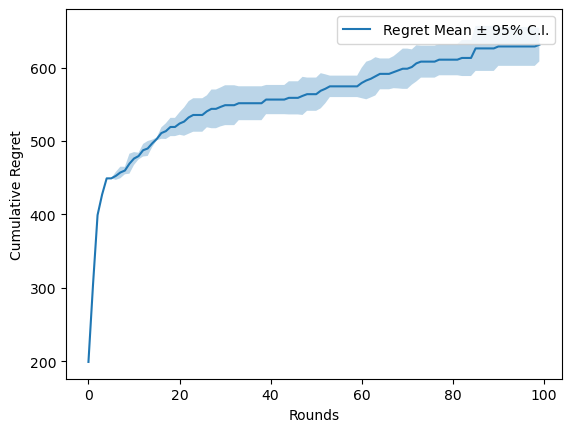

In [2]:
horizon = 100
num_trials = 3
num_products = 3
num_actions = 5
alpha = 1.0 # 1 revenue, 0 profit
kernel_L = 100.0 # kernel lengthscale
dateformat = "(%Y-%b-%d %Ih%Mm%p)"
margins = np.linspace(0.1, 0.9, num_actions)
margins_to_idx = {margins[i]: i for i in range(num_actions)}
margins = margins.reshape(1, num_actions)
margins_env = np.repeat(margins, num_products, axis=0)
demands = np.array([[0.7, 0.7, 0.3, 0.2, 0.1], [0.7, 0.6, 0.5, 0.5, 0.1], [0.9, 0.6, 0.4, 0.3, 0.2]])
user_ranges = 100 * np.ones((num_products, 2), dtype=int)

results_lst = []

for trial_i in range(num_trials):

    env = IndependentPricingEnvironment(num_products, num_actions, margins_env, 
                                        demands, user_ranges, alpha, seed=trial_i)
    optimal_actions, optimal_values, action_vals = env.compute_optimal_actions_and_values()
    
    results_lst.append({"pseudo_regret" : np.zeros((horizon, num_products)), 
                        "actions" : np.zeros((horizon, num_products))})
    
    indep_agents = []
    for i in range(num_products): 
        indep_agents.append(OptIndepPricingAgent(margins.reshape(num_actions, 1), 
                                                 kernel_L, horizon, alpha))

    for t in tqdm(range(horizon)):
        for i in range(num_products):
            results_lst[-1]["actions"][t, i] = indep_agents[i].pull()
        res = env.step(results_lst[-1]["actions"][t, :].ravel())
        for i in range(num_products):
            indep_agents[i].update(res[i, 0], res[i, 1])
            results_lst[-1]["pseudo_regret"][t, i] = res[i, 1] * (optimal_values[i] - action_vals[i, margins_to_idx[results_lst[-1]["actions"][t, i]]])
    
inst_regret_matrix = np.zeros((num_trials, horizon))
for i in range(num_trials):
    inst_regret_matrix[i, :] = np.array(results_lst[i]["pseudo_regret"]).sum(axis=1)
    
cum_regret_matrix = np.cumsum(inst_regret_matrix, axis=1)
results_mean = np.mean(cum_regret_matrix, axis=0)
results_std = 1.96 * np.std(cum_regret_matrix, axis=0) / np.sqrt(num_trials)

x_plt = np.linspace(0, horizon-1, horizon, dtype=int)
plt.plot(x_plt, results_mean[x_plt], label="Regret Mean $\pm$ 95% C.I.")
plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], 
                 results_mean[x_plt] + results_std[x_plt], alpha=0.3)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()

result_folder = "results"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
save_path = result_folder + "/indep_run_" + datetime.datetime.now().strftime(dateformat) + ".jpg"
plt.savefig(save_path)

In [3]:
for i in range(num_products):

    mu, _ = indep_agents[i].bandit_agent.regressor.compute(margins.T)

    ucbs = indep_agents[i].bandit_agent.get_optimistic_estimates()

    print(f"Product {i}: ", demands[i, :], np.round(mu, 2), np.round(ucbs, 2), "\n")

Product 0:  [0.7 0.7 0.3 0.2 0.1] [0.69 0.69 0.35 0.17 0.09] [0.82 0.72 0.57 0.39 0.31] 

Product 1:  [0.7 0.6 0.5 0.5 0.1] [0.71 0.62 0.49 0.5  0.09] [0.81 0.69 0.59 0.53 0.32] 

Product 2:  [0.9 0.6 0.4 0.3 0.2] [0.9  0.61 0.38 0.26 0.18] [0.92 0.77 0.6  0.48 0.4 ] 



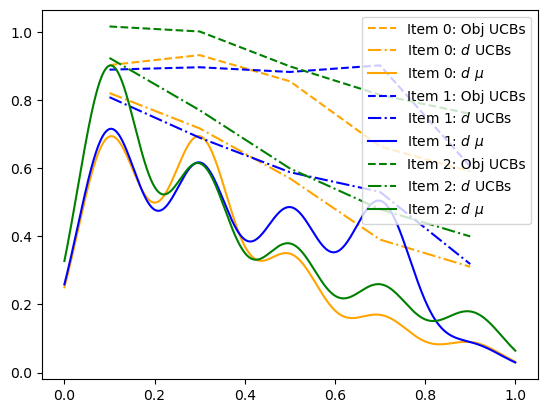

In [4]:
x_plt = np.linspace(0, 1, 1000).reshape(-1, 1)
c = ["orange", "blue", "green"]

for i in range(num_products):

    mu, sigmaest = indep_agents[i].bandit_agent.regressor.compute(x_plt)

    ucbs = indep_agents[i].bandit_agent.get_optimistic_estimates()

    obj_ucbs = (indep_agents[i].alpha + indep_agents[i].actions.ravel()) * ucbs

    plt.plot(margins.ravel(), obj_ucbs, '--', color=c[i], label=f"Item {i}: Obj UCBs")
    plt.plot(margins.ravel(), ucbs, '-.', color=c[i], label=f"Item {i}: $d$ UCBs")
    plt.plot(x_plt.ravel(), mu, color=c[i], label=f"Item {i}: $d$ $\mu$")

plt.legend()

Identical to the code above, but with functions in order to allow for parallelization

In [5]:
"""

def trial_independent_products(horizon, trial_id, num_trials, dateformat):

    start_time = time.time()
    print(f"{datetime.datetime.now().strftime(dateformat)} Starting trial {trial_id+1} of {num_trials}.")
    
    num_products = 3
    num_actions = 5
    alpha = 1.0 # 1 revenue, 0 profit
    kernel_L = 500.0 # kernel lengthscale
    margins = np.linspace(0.1, 1, num_actions)
    margins_to_idx = {margins[i]: i for i in range(num_actions)}
    margins = margins.reshape(1, num_actions)
    margins_env = np.repeat(margins, num_products, axis=0)
    demands = np.array([[0.7, 0.7, 0.3, 0.2, 0.1], [0.7, 0.6, 0.5, 0.5, 0.1], [0.9, 0.6, 0.4, 0.3, 0.2]])
    user_ranges = np.repeat(np.array([10, 10]).reshape(1, -1), num_products, axis=0)
    
    env = IndependentPricingEnvironment(num_products, num_actions, margins_env, 
                                        demands, user_ranges, alpha, seed=trial_id)
    _, optimal_values = env.compute_optimal_actions()
    action_vals = env.compute_actions_values()
    
    results_dict = {"pseudo_regret" : np.zeros((horizon, num_products)), 
                    "actions" : np.zeros((horizon, num_products))}
    
    indep_agents = []
    for i in range(num_products): 
        indep_agents.append(OptIndepPricingAgent(margins.reshape(num_actions, 1), kernel_L, horizon, alpha))

    for t in tqdm(range(horizon)):
        for i in range(num_products):
            results_dict["actions"][t, i] = indep_agents[i].pull()
        res = env.step(results_dict["actions"][t, :].ravel())
        for i in range(num_products):
            indep_agents[i].update(res[i, 0], res[i, 1])
            results_dict["pseudo_regret"][t, i] = res[i, 1] * (optimal_values[i] - action_vals[i, margins_to_idx[results_dict["actions"][t, i]]])
    
    print(f"{datetime.datetime.now().strftime(dateformat)} Terminating trial {trial_id+1} of {num_trials}. Elapsed time: {int(time.time() - start_time)} sec.")
    
    return results_dict


horizon = 10000
num_trials = 5
dateformat = "(%Y-%b-%d %Ih%Mm%p)"

results_lst = []
for i in range(num_trials):
    results_lst.append(trial_independent_products(horizon, i, num_trials, dateformat))

# results_lst must be a list with inside a dictionary with keys "pseudo_regret" and "actions"
# "pseudo_regret" is a matrix of shape (horizon, num_products) with the regrets
# "actions" is a matrix of shape (horizon, num_products) with the actions taken

x_plt = np.linspace(0, horizon-1, horizon, dtype=int)
inst_regret_matrix = np.zeros((num_trials, horizon))
for i in range(num_trials):
    inst_regret_matrix[i, :] = np.array(results_lst[i]["pseudo_regret"]).sum(axis=1)
    
cum_regret_matrix = np.cumsum(inst_regret_matrix, axis=1)
results_mean = np.mean(cum_regret_matrix, axis=0)
results_std = 1.96 * np.std(cum_regret_matrix, axis=0) / np.sqrt(num_trials)

plt.plot(x_plt, results_mean[x_plt], label="Regret Mean $\pm$ 95% C.I.")
plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], 
                 results_mean[x_plt] + results_std[x_plt], alpha=0.3)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
plt.legend()
result_folder = "results"
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
save_path = result_folder + "/indep_run_" + datetime.datetime.now().strftime(dateformat) + ".jpg"
plt.savefig(save_path)

"""

'\n\ndef trial_independent_products(horizon, trial_id, num_trials, dateformat):\n\n    start_time = time.time()\n    print(f"{datetime.datetime.now().strftime(dateformat)} Starting trial {trial_id+1} of {num_trials}.")\n    \n    num_products = 3\n    num_actions = 5\n    alpha = 1.0 # 1 revenue, 0 profit\n    kernel_L = 500.0 # kernel lengthscale\n    margins = np.linspace(0.1, 1, num_actions)\n    margins_to_idx = {margins[i]: i for i in range(num_actions)}\n    margins = margins.reshape(1, num_actions)\n    margins_env = np.repeat(margins, num_products, axis=0)\n    demands = np.array([[0.7, 0.7, 0.3, 0.2, 0.1], [0.7, 0.6, 0.5, 0.5, 0.1], [0.9, 0.6, 0.4, 0.3, 0.2]])\n    user_ranges = np.repeat(np.array([10, 10]).reshape(1, -1), num_products, axis=0)\n    \n    env = IndependentPricingEnvironment(num_products, num_actions, margins_env, \n                                        demands, user_ranges, alpha, seed=trial_id)\n    _, optimal_values = env.compute_optimal_actions()\n    act